In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random
import math
import os
import sys
import csv
import time

data = pd.read_csv("data_OptiMinds.csv")  
# Convert fractional years to datetime to understand the data better
def fractional_year_to_date(year):
    year_int = int(year)
    remainder = year - year_int
    start_of_year = datetime.datetime(year_int, 1, 1)
    days_in_year = (datetime.datetime(year_int + 1, 1, 1) - start_of_year).days
    return start_of_year + datetime.timedelta(days=remainder * days_in_year)

# Apply conversion
data['Date'] = data['Time'].apply(fractional_year_to_date)

subset_random = data.sample(n=1000, random_state=42)
print(subset_random.head())

              Time          SN                       Date
3318   1764.202980   61.059679 1764-03-15 06:58:50.319951
32638  1845.646723   43.003447 1845-08-25 01:17:44.775877
27227  1830.616297   82.596295 1830-08-13 22:45:48.499199
24615  1823.360804    0.000000 1823-05-12 16:38:39.795686
29045  1835.666254  132.597282 1835-09-01 04:22:56.440623


In [14]:
t = subset_random['Time'].values


In [15]:
def solar_cycle_model(t, params, num_cycles=10):
    """
    Models the solar cycles based on the given parameters, ensuring distinct parameters for each cycle.
    
    Args:
        t (ndarray): Array of time points.
        params (ndarray): Array of 3*num_cycles parameters 
                          [T0_1, Ts_1, Td_1, ..., T0_n, Ts_n, Td_n].
        num_cycles (int): Number of solar cycles (default is 10).
     
    Returns:
        ndarray: Predicted values of x(t).
    """
    predicted_values = np.zeros_like(t)

    for k in range(num_cycles):
        T0 = params[3 * k]       # Start time of cycle k
        Ts = params[3 * k + 1]   # Rising time of cycle k
        Td = params[3 * k + 2]   # Declining time of cycle k

        # Define the range of this cycle
        if k < num_cycles - 1:
            next_T0 = params[3 * (k + 1)]  # Start time of the next cycle
            cycle_mask = (t >= T0) & (t < next_T0)  # Prevent overlap with the next cycle
        else:
            cycle_mask = (t >= T0)  # Last cycle includes all times after T0

        t_cycle = t[cycle_mask]

        # Compute the contribution of cycle k
        if len(t_cycle) > 0:
            x_k = ((t_cycle - T0) / Ts) ** 2 * np.exp(-((t_cycle - T0) / Td) ** 2)
            predicted_values[cycle_mask] += x_k

    return predicted_values


# Loss Function: Mean Squared Error
def mse(params, t, observed_values):
    """
    Computes the Mean Squared Error (MSE) between observed data and model predictions.
    
    Args:
        params (ndarray): Model parameters [T0_1, Ts_1, Td_1, ..., T0_n, Ts_n, Td_n].
        t (ndarray): Time points of the observations.
        observed_values (ndarray): Observed sunspot data.
    
    Returns:
        float: The MSE value.
    """
    predicted_values = solar_cycle_model(t, params)
    return np.mean((observed_values - predicted_values) ** 2)


In [ ]:
"""#Improved version from GPT 
#
def simulated_annealing(x0, T0, sigma, f, n_iter=250000, burn_in=200000, verbose=True):
    """
    Performs Simulated Annealing to optimize a given function.
    
    Args:
        x0 (ndarray): Initial parameter guess.
        T0 (float): Initial temperature.
        sigma (float): Standard deviation for the proposal distribution.
        f (function): Function to minimize.
        n_iter (int): Total number of iterations (default is 250,000).
        burn_in (int): Burn-in period (default is 200,000).
        verbose (bool): If True, prints progress during optimization.
    
    Returns:
        tuple: 
            - ndarray: Array of sampled parameter values after burn-in.
            - ndarray: Best parameter set found during the optimization.
            - float: Best loss achieved.
    """
    x = x0.copy()  # Initialize x
    T = T0         # Initialize temperature
    n_params = x0.shape[0]  # Number of parameters to be optimized

    # Mean and covariance matrix for the jump distribution
    means = np.zeros(n_params)
    cov_matrix = np.diag(np.full(n_params, sigma ** 2))  # Variance is sigma^2
    
    # Size of the output array after burn_in
    size_out = int(n_iter - burn_in)
    samples = np.zeros((size_out, n_params))
    
    # Track the best solution
    best_loss = float('inf')
    best_params = None

    iter_counter = 0
    initial_loss = f(x)
    if verbose:
        print("Initial loss:", initial_loss)
    
    # Start main loop
    while iter_counter < n_iter:
        iter_counter += 1
        x_old = x.copy()
        x_proposal = x_old + np.random.multivariate_normal(means, cov_matrix)
        
        # Compute loss difference
        loss_old = f(x_old)
        loss_proposal = f(x_proposal)
        DeltaE = loss_proposal - loss_old
        
        # Metropolis accept/reject step
        if np.exp(-np.clip(DeltaE / T, -100, 100)) >= np.random.rand():
            x = x_proposal  # Accept the proposal
        else:
            x = x_old  # Reject the proposal
        
        # Track the best parameters
        if loss_proposal < best_loss:
            best_loss = loss_proposal
            best_params = x_proposal.copy()
        
        # Update temperature using exponential cooling
        T = T0 / (1 + 0.01 * iter_counter)  # Cooling schedule

        # Print progress
        if verbose and iter_counter % 10000 == 0:
            print(f"Iteration {iter_counter}, Temperature: {T:.6f}, Loss: {loss_old:.6f}")
        
        # Store parameters after burn-in
        if iter_counter > burn_in:
            samples[iter_counter - burn_in - 1, :] = x.copy()
    
    # Final output
    return samples, best_params, best_loss"""

In [3]:
# Simulated Annealing Optimization
def simulated_annealing(x0, T0, sigma, f, n_iter=2.5e5, burn_in=2e5):
    """
    Performs Simulated Annealing to optimize a given function.
    
    Args:
        x0 (ndarray): Initial parameter guess.
        T0 (float): Initial temperature.
        sigma (float): Standard deviation for the proposal distribution.
        f (function): Function to minimize.
        n_iter (int): Total number of iterations (default is 250,000).
        burn_in (int): Burn-in period (default is 200,000).
    
    Returns:
        ndarray: Array of sampled parameter values after burn-in.
    """
    x = x0.copy()  # Initialize x
    T = T0         # Initialize temperature
    n_params = x0.shape[0]  # Number of parameters to be optimized

    # Mean and covariance matrix for the jump distribution
    means = np.full(n_params, 0)
    cov_matrix = np.diag(np.full(n_params, sigma))
    
    # Size of the output array after burn_in
    size_out = int(n_iter - burn_in)
    v = np.zeros((size_out, n_params))
    
    iter_counter = 0
    print("Initial loss:", f(x))
    
    # Start main loop
    while iter_counter < n_iter:
        iter_counter += 1
        x_old = x
        x_proposal = x_old + np.random.multivariate_normal(means, cov_matrix)
        
        # Compute loss difference
        DeltaE = f(x_proposal) - f(x_old)
        
        # Metropolis accept/reject step
        if np.exp(-np.clip(DeltaE / T, -100, 100)) >= np.random.rand():
            x = x_proposal
        else:
            x = x_old
        
        # Update temperature according to schedule
        T = T0 * (1 - iter_counter / n_iter)
        
        # Print progress
        if iter_counter % 10000 == 0:
            print(f"Iteration {iter_counter}, Temperature: {T:.6f}, Loss: {f(x):.6f}")
        
        # Store parameters after burn-in
        if iter_counter > burn_in:
            v[iter_counter - int(burn_in) - 1, :] = x
    
    return v

In [16]:
def simulated_annealing(x0, T0, sigma, f, n_iter=10000, burn_in=5000):
    """
    Performs Simulated Annealing to optimize the solar cycle parameters.
    
    Args:
        x0 (ndarray): Initial parameter guess.
        T0 (float): Initial temperature.
        sigma (float): Proposal standard deviation.
        f (function): Loss function to minimize.
        n_iter (int): Total number of iterations.
        burn_in (int): Burn-in period.
    
    Returns:
        tuple: Optimized parameters and loss function evolution.
    """
    x = x0.copy()
    n_params = len(x0)
    temperature = T0
    losses = []
    best_x = x.copy()
    best_loss = f(x)

    for i in range(n_iter):
        # Propose new parameters
        x_new = x + np.random.normal(0, sigma, size=n_params)
        
        # Calculate the loss difference
        loss_old = f(x)
        loss_new = f(x_new)
        delta_e = loss_new - loss_old
        
        # Metropolis criterion
        if np.exp(-delta_e / temperature) >= np.random.rand():
            x = x_new
            if loss_new < best_loss:
                best_loss = loss_new
                best_x = x_new.copy()
        
        # Cool the temperature
        temperature = T0 / (1 + i / n_iter)
        losses.append(loss_old)
    
    # Discard burn-in period
    return best_x, np.array(losses[burn_in:])


In [17]:
# Initial start times (T0) from the paper
T0_initial = np.array([1755.2, 1766.06, 1775.5, 1784.9, 1798.4, 
                       1810.6, 1823.05, 1833.11, 1843.5, 1855.12])

# Initial rising (Ts) and declining (Td) times
num_cycles = len(T0_initial)
Ts_initial = np.full(num_cycles, 0.3)  # Rising time
Td_initial = np.full(num_cycles, 5.0)  # Declining time

# Combine into one parameter array
x0 = np.empty(num_cycles * 3)
x0[::3] = T0_initial  # Set T0 values
x0[1::3] = Ts_initial  # Set Ts values
x0[2::3] = Td_initial  # Set Td values

print("Initial Parameters:", x0)


Initial Parameters: [1.75520e+03 3.00000e-01 5.00000e+00 1.76606e+03 3.00000e-01 5.00000e+00
 1.77550e+03 3.00000e-01 5.00000e+00 1.78490e+03 3.00000e-01 5.00000e+00
 1.79840e+03 3.00000e-01 5.00000e+00 1.81060e+03 3.00000e-01 5.00000e+00
 1.82305e+03 3.00000e-01 5.00000e+00 1.83311e+03 3.00000e-01 5.00000e+00
 1.84350e+03 3.00000e-01 5.00000e+00 1.85512e+03 3.00000e-01 5.00000e+00]


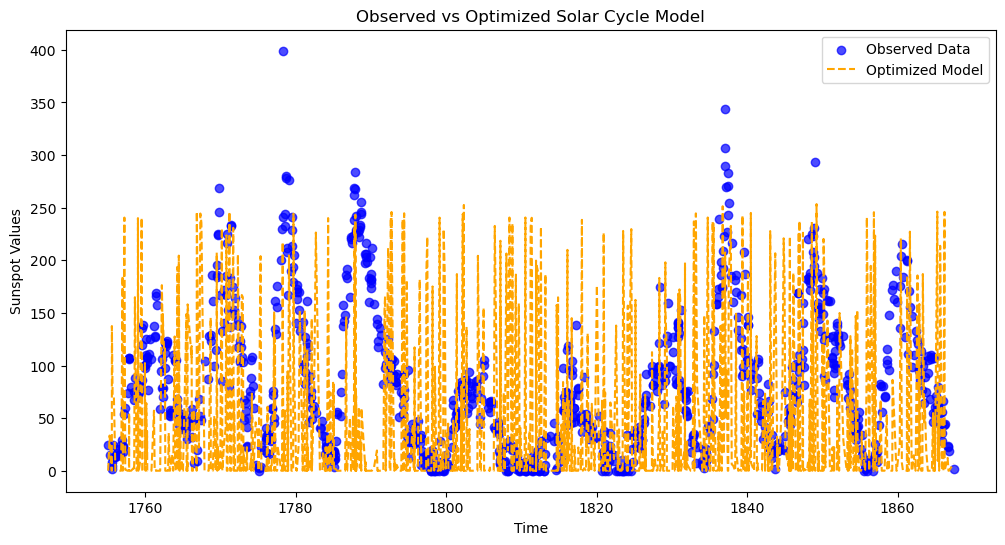

In [ ]:
####### TEST 1
#######

subset_random = subset_random.sort_values(by="Time")
t = subset_random["Time"].values
observed_values = subset_random["SN"].values  # Replace "SN" with your data column name
print(f"t: {t.shape}, observed_values: {observed_values.shape}, predicted_values: {predicted_values.shape}")

plt.figure(figsize=(12, 6))
plt.scatter(t, observed_values, label="Observed Data", color="blue", alpha=0.7)
plt.plot(t, predicted_values, label="Optimized Model", color="orange", linestyle="--")
plt.title("Observed vs Optimized Solar Cycle Model")
plt.xlabel("Time")
plt.ylabel("Sunspot Values")
plt.legend()
plt.show()


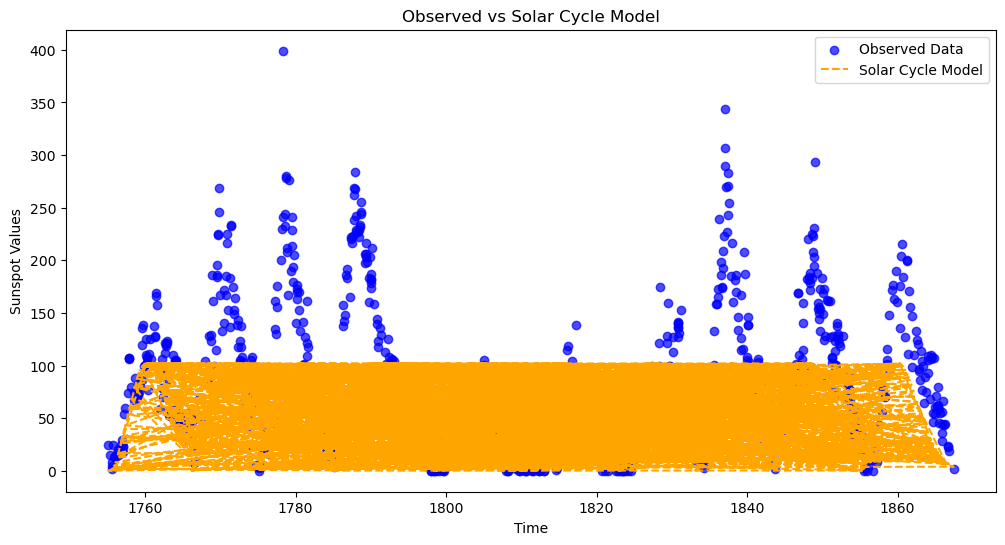

In [18]:
####### TEST 2
#######

# Subset data for testing
subset_random = data.sample(n=1000, random_state=42)
t = subset_random['Time'].values  # Replace 'Time' with the actual column name
observed_values = subset_random['SN'].values  # Replace 'SN' with the actual column name

# Initial parameters (from the paper)
T0_initial = np.array([1755.2, 1766.06, 1775.5, 1784.9, 1798.4,
                       1810.6, 1823.05, 1833.11, 1843.5, 1855.12])
Ts_initial = np.full(len(T0_initial), 0.3)
Td_initial = np.full(len(T0_initial), 5.0)
x0 = np.empty(len(T0_initial) * 3)
x0[::3] = T0_initial
x0[1::3] = Ts_initial
x0[2::3] = Td_initial

# Compute predictions using the revised model
predicted_values = solar_cycle_model(t, x0)

# Plot observed vs. predicted values
plt.figure(figsize=(12, 6))
plt.scatter(t, observed_values, label="Observed Data", color="blue", alpha=0.7)
plt.plot(t, predicted_values, label="Solar Cycle Model", color="orange", linestyle="--")
plt.title("Observed vs Solar Cycle Model")
plt.xlabel("Time")
plt.ylabel("Sunspot Values")
plt.legend()
plt.show()


## NEW VERSION

Initial Parameters: [1.75520e+03 3.00000e-01 5.00000e+00 1.76606e+03 3.00000e-01 5.00000e+00
 1.77550e+03 3.00000e-01 5.00000e+00 1.78490e+03 3.00000e-01 5.00000e+00
 1.79840e+03 3.00000e-01 5.00000e+00 1.81060e+03 3.00000e-01 5.00000e+00
 1.82305e+03 3.00000e-01 5.00000e+00 1.83311e+03 3.00000e-01 5.00000e+00
 1.84350e+03 3.00000e-01 5.00000e+00 1.85512e+03 3.00000e-01 5.00000e+00]


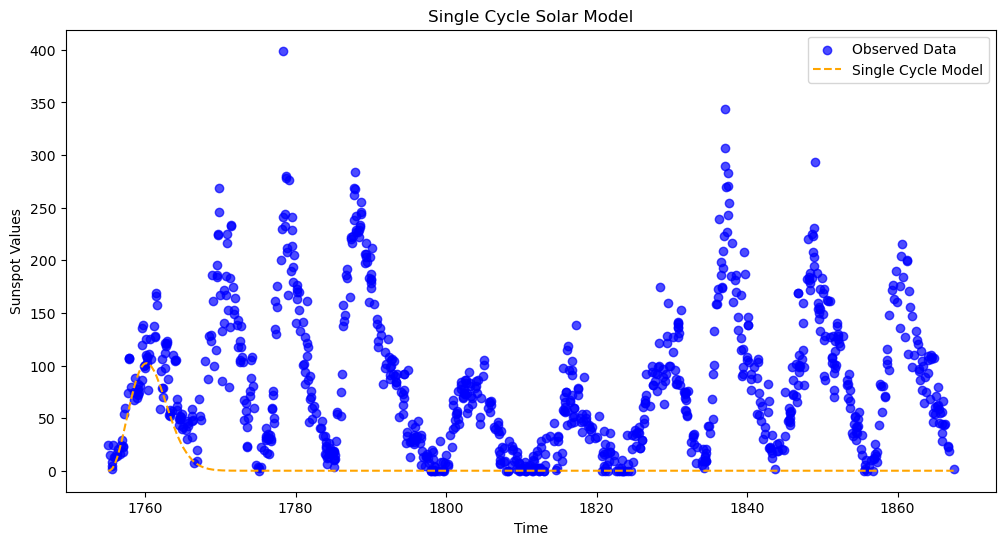

In [19]:
def solar_cycle_model(t, params, num_cycles=10):
    """
    Models the solar cycles based on the given parameters, ensuring distinct parameters for each cycle.
    
    Args:
        t (ndarray): Array of time points.
        params (ndarray): Array of 3*num_cycles parameters 
                          [T0_1, Ts_1, Td_1, ..., T0_n, Ts_n, Td_n].
        num_cycles (int): Number of solar cycles (default is 10).
     
    Returns:
        ndarray: Predicted values of x(t).
    """
    predicted_values = np.zeros_like(t)

    for k in range(num_cycles):
        T0 = params[3 * k]       # Start time of cycle k
        Ts = params[3 * k + 1]   # Rising time of cycle k
        Td = params[3 * k + 2]   # Declining time of cycle k

        # Define the range of this cycle
        if k < num_cycles - 1:
            next_T0 = params[3 * (k + 1)]  # Start time of the next cycle
            cycle_mask = (t >= T0) & (t < next_T0)  # Prevent overlap with the next cycle
        else:
            cycle_mask = (t >= T0)  # Last cycle includes all times after T0

        t_cycle = t[cycle_mask]

        # Compute the contribution of cycle k
        if len(t_cycle) > 0:
            x_k = ((t_cycle - T0) / Ts) ** 2 * np.exp(-((t_cycle - T0) / Td) ** 2)
            predicted_values[cycle_mask] += x_k

    return predicted_values


# Initial parameters from the paper
T0_initial = np.array([1755.2, 1766.06, 1775.5, 1784.9, 1798.4, 
                       1810.6, 1823.05, 1833.11, 1843.5, 1855.12])
Ts_initial = np.full(len(T0_initial), 0.3)
Td_initial = np.full(len(T0_initial), 5.0)
x0 = np.empty(len(T0_initial) * 3)
x0[::3] = T0_initial
x0[1::3] = Ts_initial
x0[2::3] = Td_initial

print("Initial Parameters:", x0)

# Extract and sort time points from subset_random
subset_random = subset_random.sort_values(by="Time")
t = subset_random['Time'].values
observed_values = subset_random['SN'].values  # Replace 'SN' with the correct column name


# Test the model for one cycle
predicted_values = solar_cycle_model(t, x0, num_cycles=1)

# Plot the results
plt.figure(figsize=(12, 6))
plt.scatter(t, observed_values, label="Observed Data", color="blue", alpha=0.7)
plt.plot(t, predicted_values, label="Single Cycle Model", color="orange", linestyle="--")
plt.title("Single Cycle Solar Model")
plt.xlabel("Time")
plt.ylabel("Sunspot Values")
plt.legend()
plt.show()




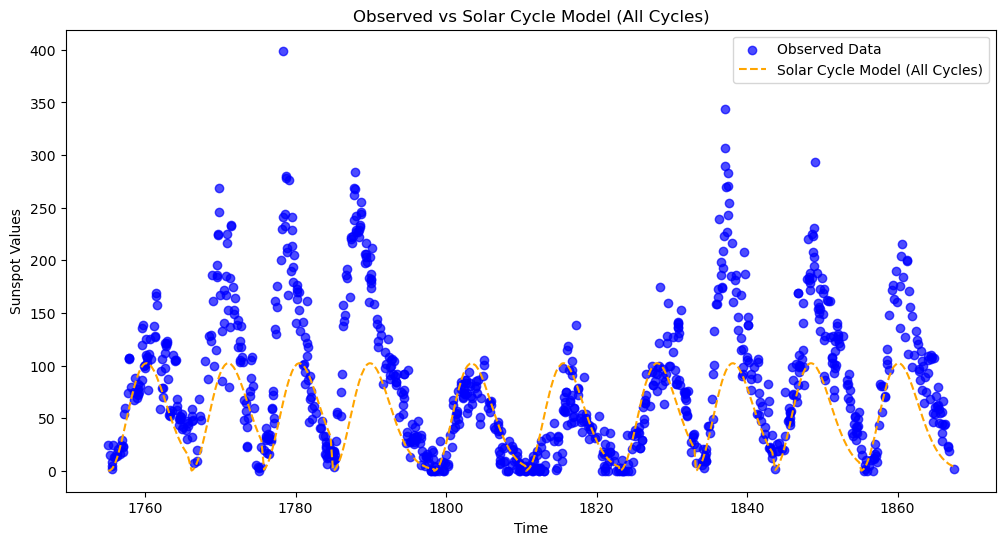

In [ ]:
# Compute predictions using the model for all cycles
num_cycles = len(T0_initial)  # Number of cycles based on initial parameters
predicted_values = solar_cycle_model(t, x0, num_cycles=num_cycles)

# Plot observed vs. predicted values (all cycles)
plt.figure(figsize=(12, 6))
plt.scatter(t, observed_values, label="Observed Data", color="blue", alpha=0.7)
plt.plot(t, predicted_values, label="Solar Cycle Model (All Cycles)", color="orange", linestyle="--")
plt.title("Observed vs Solar Cycle Model (All Cycles)")
plt.xlabel("Time")
plt.ylabel("Sunspot Values")
plt.legend()
plt.show()
